In [2]:
import numpy as np
import cvxpy as cp
import qutip
from qutip import wigner, fock, Qobj, displace, destroy, tensor, qeye, coherent, ket2dm, expect, fidelity, fock_dm, ptrace
from qutip.visualization import plot_wigner_fock_distribution, plot_wigner, matrix_histogram, matrix_histogram_complex
from qutip.wigner import wigner
from scipy.special import genlaguerre
from math import sqrt, factorial
import matplotlib.pyplot as plt
from scipy.linalg import lstsq, eigh, svd
from scipy.sparse.linalg import LinearOperator, lsqr
import h5py
from tqdm.auto import tqdm # progress bar
from matplotlib import colors
from tcsim.visualization import*
from tcsim.gates import*
from tcsim.system import*

def vectorize(rho):
    """
    Turn hermitian matrix rho into a real vector
    vectorize(rho)[:d] = diag(rho)
    vectorize(rho)[d:d + d*(d-1)/2] = Re[upper_triangle(rho)]
    vectorize(rho)[d + d*(d-1)/2:]  = Im[upper_triangle(rho)]
    """
    d = rho.shape[0]  ## the shape of first column - dimension of matrix, e.g. 3x3 matrix d = 3
    n_offd = d*(d-1)//2 
    ret = np.zeros(d**2) #array of zeros with dimensionality d**2
    i = 0
    for m in range(d):
        ret[m] = rho[m, m].real #mth entry in ret is real part of (m,m) diagonal entry of matrix, capped at d
        for n in range(m+1, d):
            ret[d+i] = rho[m, n].real  #set d+ith entry in ret to real part of (m,n) off diagonal entry of matrix
            ret[d+n_offd+i] = rho[m, n].imag
            i += 1
    return ret


def matricize(rvec):
    """
    Invert the vectorize operation such that matricize(vectorize(rho)) == rho
    """
    d = int(np.sqrt(len(rvec)))
    n_offd = d*(d-1)//2
    ret = np.diag(rvec[:d]).astype(np.complex) # 将rvec[:d]转化为一个对角矩阵，并且用a+jb的形式表示
    i = 0
    for m in range(d):
        for n in range(m+1, d):
            real = rvec[d+i]
            imag = rvec[d+n_offd+i]
            val = real + 1j*imag
            ret[m, n] = val
            ret[n, m] = val.conj()
            i += 1
    return ret


def complex_char_mat(disps, d):
    n_disp = len(disps)
    n_offd = (d*(d-1))//2
    dm = np.zeros((n_disp, d*d), dtype=np.complex)
    alpha = disps
    i = 0
    B = abs(alpha)**2
    for n in range(d):
        dm[:, n] = genlaguerre(n, 0)(B)
        for m in range(n+1, d):
            off_d = np.sqrt(factorial(n)/factorial(m)) * genlaguerre(n, m-n)(B)
            dm[:, d+i] = (off_d * (alpha**(m-n) + (-alpha.conjugate())**(m-n)))
            dm[:, d + n_offd + i] = (1j * off_d * (alpha**(m-n) - (-alpha.conjugate())**(m-n)))
            i += 1
    dm = np.einsum('ij,i->ij', dm, np.exp(-B / 2))
    return dm

def reconstruct_char_complex(char, disps, dim):
    M = complex_char_mat(disps, dim)
    rv = lsqr(M, char,damp=2)[0]
    rho = matricize(rv)
    return rho


c:\Users\jonat\AppData\Local\pypoetry\Cache\virtualenvs\tcsim-vg60nFMD-py3.9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def char_ops(hilbert_size, betas):
    ops_list = []

    for beta in tqdm(betas):
        D = displace(100, beta) # need the larger Hilbert space to not get erroneous operators for large beta
        op = D
        op = Qobj(op[:hilbert_size, :hilbert_size]) # truncate to wanted Hilbert space size
        ops_list.append(op)

    return ops_list

In [5]:
def reconstruct_char_complex_convex(char, disps, dim):
    # construct vectors
    basis_vectors = []
    for i in range(dim):
        vector = fock(dim, i)
        basis_vectors.append(vector.full())

    # construct operators
    basis_dms = []
    for vector1 in basis_vectors:
        for vector2 in basis_vectors:
            dm = np.outer(vector2, vector1)
            basis_dms.append(dm)
    Pis = char_ops(dim, disps)
    A = np.zeros((len(Pis), dim*dim), dtype=complex)
    
    for index, a in tqdm(np.ndenumerate(A)):
        A[index] = np.trace(Pis[index[0]].full() @ basis_dms[index[1]])
    
    X = cp.Variable((dim,dim), hermitian=True)
    cost = cp.norm(A @ cp.reshape(X, (dim*dim)) - char, 2)
    constraints = [cp.trace(X) == 1, X >> 0]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()
    reconstructed_rho = Qobj(X.value)
    return reconstructed_rho

# Load and PLot Data

In [6]:
def make_disps(xmax, N):
    xs = np.linspace(-xmax, xmax, N)
    X, Y = np.meshgrid(xs, xs)
    return (X + Y*1j).flatten()

# Create theoretical state and tryout reconstruction

In [7]:


#psi = tensor(Iq,squeeze(N,calc_squeez_parameter(3)))*vac
psi = tensor(fock(2,0),coherent(N,1*np.exp(1j*np.pi/4))).unit()
# psi = tensor(fock(2,0),fock(N,1)+fock(N,0)).unit()
xvec = np.linspace(-3,3,31)
char_real, char_im = char_func_grid(psi,xvec)

char_func_flat = (char_real+1j*char_im).flatten()

In [8]:
rho_ideal=qt.ptrace(psi*psi.dag(),1).unit()

(-3.1, 3.099999999999999, -3.1, 3.099999999999999)

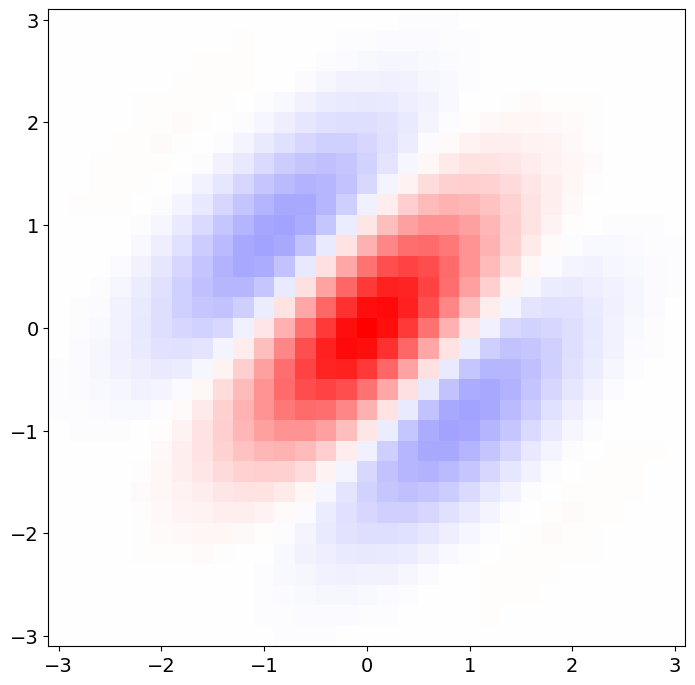

In [9]:
plt.pcolormesh(xvec,xvec,np.real(char_func_flat.reshape((31,31))),cmap="bwr",vmin=-1,vmax=1)
plt.axis("square")

In [10]:
re_rho = reconstruct_char_complex_convex(char_func_flat,make_disps(3,31), 20)
rho=Qobj(re_rho)


100%|██████████| 961/961 [00:10<00:00, 91.33it/s] 
384400it [00:05, 70027.14it/s]


Text(0.5, 1.0, 'char')

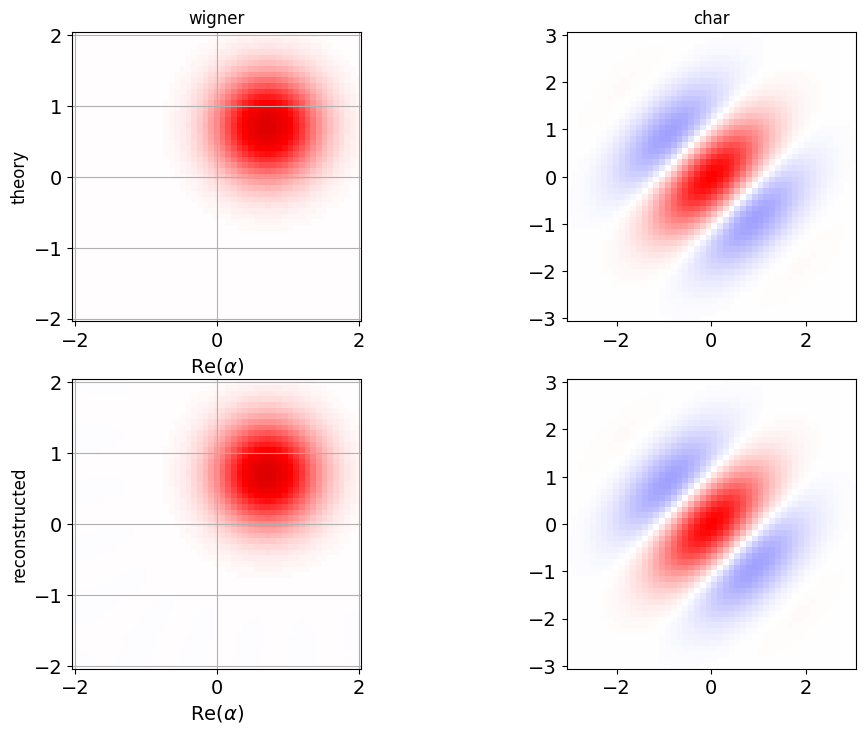

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [12]:
rho_tensor = tensor(qt.fock(2,0)*qt.fock(2,0).dag(),rho)

fig, ax = plt.subplots(2,2)
plot_wigner(psi, ax = ax[0][0])
plot_char(psi, ax = ax[0][1]) 

plot_wigner(rho_tensor.unit(), ax = ax[1][0])
plot_char(rho_tensor.unit(), ax = ax[1][1],) 



ax[0][0].set_ylabel('theory', fontsize=12)
ax[1][0].set_ylabel('reconstructed', fontsize=12)
ax[0][0].set_title('wigner', fontsize=12)
ax[0][1].set_title('char', fontsize=12)

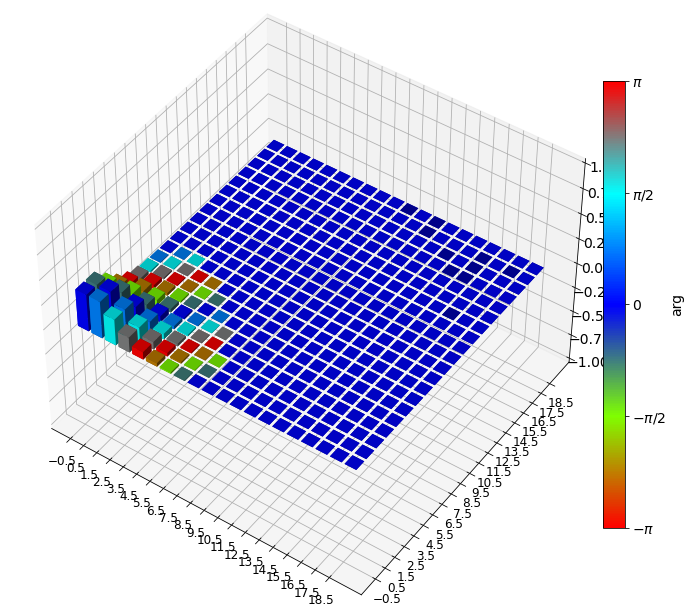

In [16]:
# visualize the DM

fig, ax = matrix_histogram_complex(ptrace((ket2dm(psi)),1)[:20,:20], limits=[-1,1])

ax.view_init(azim=-55, elev=45)

plt.show()

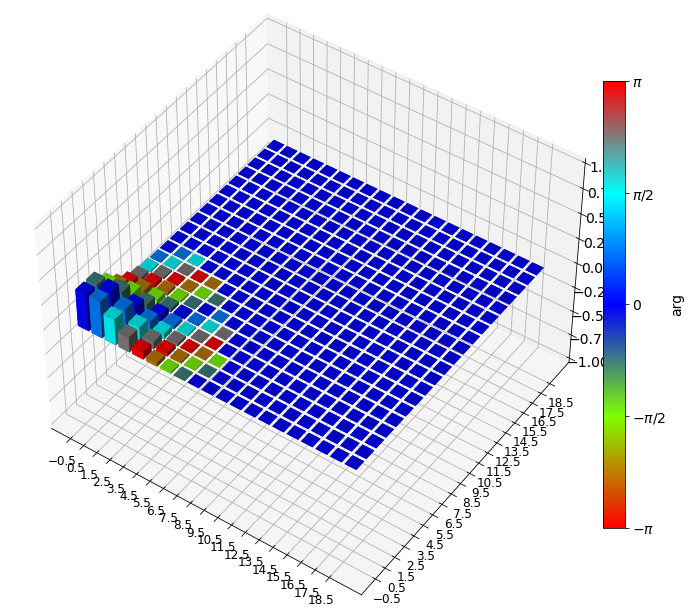

In [17]:
# visualize the DM

fig, ax = matrix_histogram_complex((rho).unit(), limits=[-1,1])


ax.view_init(azim=-55, elev=45)

plt.show()

# Try real Data

<ipython-input-18-cdae241beead>:90: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_data, y_data, zscale, cmap = 'bwr',vmin=-1,vmax=1) # [4:31]


Text(0.5, 1.0, 'Characteristic_function')

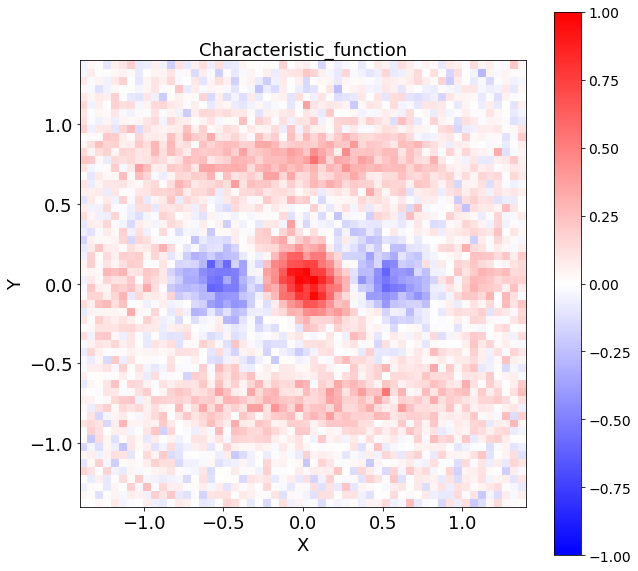

In [18]:
import h5py
import numpy.ma as ma
import os

d=r"/mnt/d/lab/TransmonCavity/cat3/"
#     filepath = r"/mnt/d/lab/TransmonCavity/150616_panther_ECD_char_postselect.h5"
files = [f for f in os.listdir(d) if f.endswith('real.h5')]
dg = []
de = []
for kk in range(len(files)):
    fname = d + files[kk]
    df = h5py.File(fname, "r")
    data = df["data"]
    data_i = data["I"][:]
    x = data["x"][:, 0][:, 0]
    n_points = len(x)  # sweep points
    thresh = 6.30337300715842e-05 #-3.112326057411744e-05
    ss_data = np.where(data_i < thresh, 1, 0)
    m0 = ss_data[:, 0::3]
    m1 = ss_data[:, 1::3] 
    m2 = ss_data[:, 2::3]
    m1_g = ma.masked_array(m1, mask=m0)
    m2_g = ma.masked_array(m2, mask=m0)

    ## only care about last two measurements
    proj_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(n_points, n_points) * 2 - 1
    proj_e = ma.masked_array(m2, mask=np.logical_not(m1)).mean(axis=0).reshape(n_points, n_points) * 2 - 1

    ## condition on the first measurement as well
    double_ps_g = ma.masked_array(m2_g, mask=m1_g).mean(axis=0).reshape(n_points, n_points) * 2 - 1
    double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g)).mean(axis=0).reshape(n_points, n_points) * 2 - 1

    dg.append(double_ps_g)
    de.append(double_ps_e)

    
dg = np.array(dg)
de = np.array(de)


proj_g = dg.mean(axis=0)
proj_e = de.mean(axis=0)

#     file = h5py.File(filepath, "r")
# data = file["data"]
# data_i = data["I"][:]
# # state = data["state"][:]
# x = data["x"][:, 0][:, 0]
# n_points = len(x)  # sweep points
# thresh = 1.736310313628283e-05
# ss_data = np.where(data_i < thresh, 1, 0)
# m1 = ss_data[:, 0::2]  # .mean(axis=0) # first measurement, we use as mask
# m2 = ss_data[:, 1::2]  # .mean(axis=0) # second measurement
# mask = np.zeros_like(m1)
# mx_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(n_points, n_points) * 2 - 1
# mx_e = (
#     ma.masked_array(m2, mask=np.logical_not(m1))
#     .mean(axis=0)
#     .reshape(n_points, n_points)
# ) * 2 - 1
z = np.array(proj_g)
# filepath = (
#     r"/mnt/d/lab/TransmonCavity/224242_panther_ECD_char.h5"
# )
# f = h5py.File(filepath, "r")
# data_iavg = f['data']['I_AVG']
# data_iavg.shape
# z = np.array(data_iavg) # minus sign to make epxeriment and simulation have the same polarity

z_flat = z.flatten()
def scale(col, min, max):
    range = col.max() - col.min()
    a = (col - col.min()) / range
    return a * (max - min) + min

# zscale = scale(z+0.03,-.6, 1)
# zscale=z-0.02
zscale=z+0.03
zscale/=np.max(zscale)
z_flat = zscale.flatten()

# Data Plotting
# x_data = np.array(f['data']['x']) # -1.8 to including 1.8
# y_data = np.array(f['data']['y'])
x_data=x
y_data=x

fig, ax = plt.subplots(figsize = (10,10) )
ax.set_aspect('equal')
plt.pcolormesh(x_data, y_data, zscale, cmap = 'bwr',vmin=-1,vmax=1) # [4:31]
plt.colorbar()
plt.xlabel("X", fontsize = 18)
plt.ylabel('Y', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Characteristic_function', fontsize=18)

In [19]:
np.max(z_flat)

1.0

In [20]:
x

array([-1.40000000e+00, -1.35000000e+00, -1.30000000e+00, -1.25000000e+00,
       -1.20000000e+00, -1.14999999e+00, -1.09999999e+00, -1.04999999e+00,
       -9.99999993e-01, -9.49999992e-01, -8.99999991e-01, -8.49999990e-01,
       -7.99999990e-01, -7.49999989e-01, -6.99999988e-01, -6.49999987e-01,
       -5.99999987e-01, -5.49999986e-01, -4.99999985e-01, -4.49999984e-01,
       -3.99999984e-01, -3.49999983e-01, -2.99999982e-01, -2.49999981e-01,
       -1.99999981e-01, -1.49999980e-01, -9.99999791e-02, -4.99999784e-02,
        2.23517418e-08,  5.00000231e-02,  1.00000024e-01,  1.50000025e-01,
        2.00000025e-01,  2.50000026e-01,  3.00000027e-01,  3.50000028e-01,
        4.00000028e-01,  4.50000029e-01,  5.00000030e-01,  5.50000031e-01,
        6.00000031e-01,  6.50000032e-01,  7.00000033e-01,  7.50000034e-01,
        8.00000034e-01,  8.50000035e-01,  9.00000036e-01,  9.50000037e-01,
        1.00000004e+00,  1.05000004e+00,  1.10000004e+00,  1.15000004e+00,
        1.20000004e+00,  

In [21]:
# # claculate the disps grid 
# x = np.array(f['data']['x'])
# y = np.array(f['data']['y'])
x,y=np.meshgrid(x,x)
disps = (x + 1j*y).flatten()


In [25]:
z_flat_imag=0


In [26]:
z_flatten_total =z_flat+ 1j*z_flat_imag

In [27]:
z_flatten_total

array([-0.00296278+0.j,  0.00357843+0.j,  0.02710018+0.j, ...,
        0.05801801+0.j, -0.10896052+0.j, -0.07991821+0.j])

In [28]:
rho = Qobj(reconstruct_char_complex_convex(z_flatten_total, disps*2.6, 20))

rho_tensor = qt.tensor(qt.fock(2,0)*qt.fock(2,0).dag(),rho.unit())



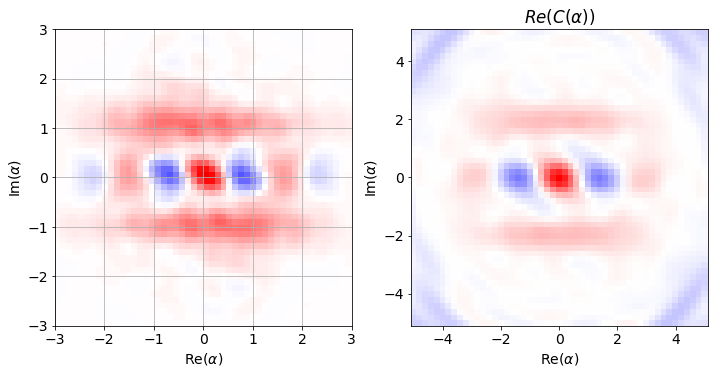

<Figure size 432x360 with 0 Axes>

<Figure size 432x360 with 0 Axes>

In [29]:
fig, ax = plt.subplots(1,2)

plot_wigner(rho_tensor.unit(), ax = ax[0], vmin = -2/np.pi, vmax = 2/np.pi,max_alpha=3.0)
plot_char(rho_tensor.unit(), ax = ax[1], vmin = -1, vmax = 1,max_alpha=5.0)

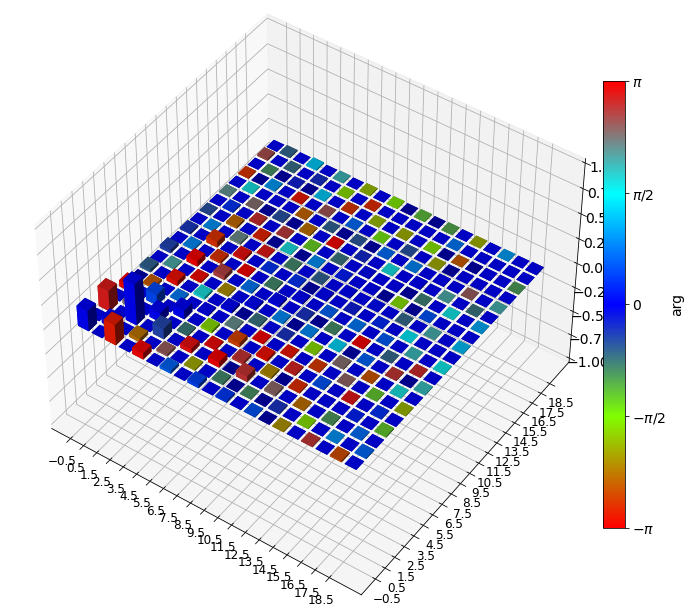

In [30]:
fig, ax = matrix_histogram_complex((rho).unit(), limits=[-1,1])


ax.view_init(azim=-55, elev=45)

plt.show()

## Previous method

In [31]:
rho = Qobj(reconstruct_char_complex(z_flatten_total, disps*2.6, 20))

rho_tensor = qt.tensor(qt.fock(2,0)*qt.fock(2,0).dag(),rho.unit())

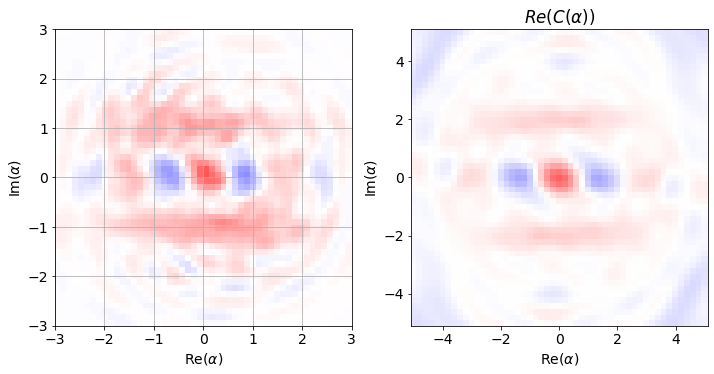

<Figure size 432x360 with 0 Axes>

<Figure size 432x360 with 0 Axes>

In [32]:
fig, ax = plt.subplots(1,2)

plot_wigner(rho_tensor.unit(), ax = ax[0], vmin = -2/np.pi, vmax = 2/np.pi,max_alpha=3.0)
plot_char(rho_tensor.unit(), ax = ax[1], vmin = -1, vmax = 1,max_alpha=5.0)